In [ ]:
from copy import deepcopy

import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['font.family']= 'open sans'
from matplotlib.colors import LogNorm

from scipy.optimize import least_squares
from scipy.stats import gaussian_kde

from rdn.validation import Simulation
from rdn.fitting.models import LocalGaussModelTilde
from rdn.defaults import pardict_from_result


Set up the model parameters

In [ ]:
model = LocalGaussModelTilde()

model_p_dict = pardict_from_result(
    'output/multi_fitting/Multi_LocalGaussModelTilde/NLLAdast/1_3_5_7_Spine_data_fides_1200.hdf5', 
    Chi=1, dendrite_length=1000, N_mean=5000, run_index=0)

simulation_time = 40
spine_number = 200
inter_spine_distance = 1

model_p_dict['Pi'] /= 10
model_p_dict['tau_N'] *= 2
model_p_dict['tau_K'] *= 2


/home/janko/code/pyPESTO/pypesto/store/read_from_hdf5.py:124: UserWarning: You are loading a problem. This problem is not to be used without a separately created objective.
  warnings.warn(



Basal K distribution:
- Sample size: 59
- Mean: 4017.7537474693586 +- 2746.5237188826472
- Anderson test on log: AndersonResult(statistic=np.float64(0.36243150482356157), critical_values=array([0.543, 0.619, 0.742, 0.866, 1.03 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(8.106764691950193), scale=np.float64(0.6245301761906116))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

Basal N distribution:
- Sample size: 58
- Mean: 8070.943955026876 +- 5225.598876296613
- Anderson test on log: AndersonResult(statistic=np.float64(0.5003716373876728), critical_values=array([0.543, 0.618, 0.741, 0.865, 1.029]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(8.820978310112448), scale=np.float64(0.5968557991311232))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

Correlation matrix between log K_b and log

Import the datasets

In [ ]:
bdf = pd.read_csv('data/validation_data/chindemi_data/banerjee.csv')
edf = pd.read_csv('data/validation_data/chindemi_data/egger.csv')
gdf = pd.read_csv('data/validation_data/goda_data/stim_norm_2_vs_base.csv')

Plotting parameters

In [ ]:
c_K = 'tab:green'
c_N = 'mediumvioletred'
c_P = 'tab:blue'

Auxiliary functions

In [ ]:
def simulate_data(model_p_dict, n_experiments, **kwargs):
    '''simulates n_experiments. Returns tuple with:
        - X (basal sizes at stimulations)
        - Y (relative change at stimulations)
    '''
    
    mpd = deepcopy(model_p_dict)

    # Altered protocol
    if kwargs.get('ns_fraction'): mpd['Ns'] *= kwargs.get('ns_fraction')
    if kwargs.get('ks_fraction'): mpd['Ks'] *= kwargs.get('ks_fraction')

    stim_idxes = torch.tensor([100])
    simulation = Simulation(model = model,
                        model_p_dict = mpd,
                        simulation_time = simulation_time,
                        spine_number = spine_number,
                        inter_spine_distance = inter_spine_distance,
                        stim_indexes = stim_idxes)

    bsb, _, rsb = simulation.run(n_experiments)

    X = bsb[2,stim_idxes,:].flatten()
    Y = rsb[2,stim_idxes,:].flatten()

    return X, Y

Left panel

In [ ]:
def activation_function(x, top, sigma):
    '''gaussian like activation function,
    centered at 0'''
    
    return top*np.exp(-(x)**2/sigma**2)


def plot_plasticity_panel(axs, X_spines, plot_spine_idxes, data, stim_idx, neuron_idx):
    '''plots the plasticity panel on the dendritic segment,
    consisting of a potentiation profile and a barplot with
    the catalyst balance'''
    
    rsb, rk, rn = data

    # Relative size plot
    ax = axs[0]

    ax.errorbar(
        X_spines, rsb[3,plot_spine_idxes,stim_idx],
        c=c_P, fmt='-o',
        markeredgewidth=0,
        markersize=4,
        linewidth=1,
        label=r'$V^{(i)}$',
    )
    ax.fill_between(X_spines, 1, rsb[3,plot_spine_idxes,stim_idx],
                    color=c_P, alpha=0.2)
    ax.axhline(y=1, c='gray', alpha=0.2, linewidth=1)

    ax.legend(frameon=False, loc=(.03,.3), ncols=2, fontsize=8, markerscale=1,
              columnspacing=0.3)

    ax.set_ylim(0.7,2.5)
    ax.text(-4.2,2.2,f'Example neuron {neuron_idx}', fontsize=10, fontweight='regular')
    
    # Catalyst relative variation
    ax = axs[1]
    ax.bar(X_spines-0.1, rk[3,plot_spine_idxes,stim_idx], width=0.2, color=c_K, alpha=0.5,
           label=r'$K^{(i)}$')
    ax.bar(X_spines+0.1, rn[3,plot_spine_idxes,stim_idx], width=0.2, color=c_N, alpha=0.5,
           label=r'$N^{(i)}$')

    ax.legend(frameon=False, loc=(.03,.3), ncols=2, fontsize=8, markerscale=0.1,
              columnspacing=0.3)

    ax.set_ylim(0,10)
    ax.set_ylabel(f'post-basal\nratio', y=2, fontsize=10)



def plot_plasticity_visualization(fig):
    '''plots the left panel of the figure, showing
    different instances of plasticity'''

    ##############
    # Simulation #
    ##############
    
    n_experiments = 20
    plot_spine_idxes = torch.arange(96,105)
    stim_idxes = torch.tensor([100])

    simulation = Simulation(model = model,
                        model_p_dict = model_p_dict,
                        simulation_time = simulation_time,
                        spine_number = spine_number,
                        inter_spine_distance = inter_spine_distance,
                        stim_indexes = stim_idxes)

    _, _, rsb, kb, kbb, nb, nbb = simulation.run_return_all(n_experiments, seed=10)
    rk = kb/kbb 
    rn = nb/nbb

    ### Average quantities for the final plot
    avg_rsb = rsb[3,plot_spine_idxes,:].mean(axis=1)
    avg_rk = rk[3,plot_spine_idxes,:].mean(axis=1)
    avg_rn = rn[3,plot_spine_idxes,:].mean(axis=1)

    sem_rsb = rsb[3,plot_spine_idxes,:].std(axis=1)/np.sqrt(n_experiments)
    sem_rk = rk[3,plot_spine_idxes,:].std(axis=1)/np.sqrt(n_experiments)
    sem_rn = rn[3,plot_spine_idxes,:].std(axis=1)/np.sqrt(n_experiments)

    # Get some potentiated and some depressed indexes
    pot_idx = torch.where(rsb[3,100,:]>1)[0][:2] 
    dep_idx = torch.where(rsb[3,100,:]<1)[0][:2]
    
    
    ############
    # Plotting #
    ############

    axs = fig.subplots(
        13,1,
        height_ratios=(
            .5,.2,
            .6,.3,.2,
            .6,.3,.2,
            .6,.3,.2,
            .6,.3        
        )
    )

    X_activation = np.linspace(-4,4,100)
    X_spines = torch.arange(-4,5)

    # Plot the activation profile
    ax = axs[0]
    ax.plot(X_activation, activation_function(X_activation, model_p_dict['Ks'], model_p_dict['sigma_K']),
            c=c_K, alpha=0.5, label='induced K')
    ax.plot(X_activation, activation_function(X_activation, model_p_dict['Ns'], model_p_dict['sigma_N']),
            c=c_N, alpha=0.5, label='induced N')

    ax.legend(frameon=False, loc=(.03,.35), fontsize=8, markerscale=0.1)

    ax.set_title('Potentiation protocol: different realizations', y=1.2)

    # Plot the single plasticity instances
    plot_plasticity_panel(axs[[2,3]], X_spines, plot_spine_idxes, (rsb, rk, rn), pot_idx[0], 1)
    plot_plasticity_panel(axs[[5,6]], X_spines, plot_spine_idxes, (rsb, rk, rn), dep_idx[0], 2)
    plot_plasticity_panel(axs[[8,9]], X_spines, plot_spine_idxes, (rsb, rk, rn), pot_idx[1], 3)

    # Plot the average plasticity
    ax = axs[-2]
    ax.errorbar(X_spines, avg_rsb, sem_rsb, fmt='.-', elinewidth=2, capsize=3, markersize=8,
                label=r'$V^{(i)}$')
    ax.fill_between(X_spines, 1, avg_rsb, alpha=0.2)

    ax.legend(frameon=False, loc=(.03,.3), ncols=2, fontsize=8, markerscale=1,
              columnspacing=0.3)
    ax.set_ylim(0.7,2.5)
    ax.text(-4.2,2.2,f'Average across neurons', fontsize=10, fontweight='regular')

    # Plot the average catalyst balance
    ax = axs[-1]
    ax.bar(X_spines-0.1, avg_rk, yerr=sem_rk, 
        width=0.2, color=c_K, ecolor=c_K, label=r'$K^{(i)}$')
    ax.bar(X_spines+0.1, avg_rn, yerr=sem_rn,
        width=0.2, color=c_N, ecolor=c_N, label=r'$N^{(i)}$')
    
    ax.legend(frameon=False, loc=(.03,.3), ncols=2, fontsize=8, markerscale=0.1,
              columnspacing=0.3)

    ax.set_ylim(0,10)
    
    ax.set_xlabel(r'Distance from stimulus $[\mu m]$', fontsize=12)
    ax.set_ylabel('average\npost-basal ratio', y=1.6, fontsize=10)

    for ax in axs:
        for k, v in ax.spines.items():
            if k !='left': v.set_visible(False)
                
    for ax in axs[[0,3,6,9,12]]: ax.spines['bottom'].set_visible(True)

    for ax in axs[[2,5,8,11]]: ax.set_xticks([])

    for ax in axs[[1,4,7,10]]: ax.remove()


Center column

In [ ]:
def plot_plasticity_phase_space(ax, mpd, seed=2025):
    '''plots the plasticity phase for the stimulated spine
    given a certain stimulus'''

    ##############
    # Simulation #
    # ############
    # (i noticed that R and delta R don't really change a
    # lot, we can use only one shot)

    simulation = Simulation(model = model,
                    model_p_dict = mpd,
                    simulation_time = simulation_time,
                    spine_number = 100,
                    inter_spine_distance = inter_spine_distance,
                    stim_indexes = torch.tensor([5]))

    rbs, deltars = simulation.run_r_delta_r(2, seed=seed)

    R, deltaR = rbs[2,0], deltars[2,0]


    #############
    # Preparing #
    #############
    N = np.linspace(100,10000,100)
    K = N

    KK, NN = np.meshgrid(N,K)

    def inv_size_f(N):
        return (
            N * mpd['Ks']/mpd['Ns'] /
            (1 + deltaR/R + deltaR/R/mpd['Ns'] * N)
        )

    def red_model(N, K):

        N, K = np.meshgrid(N, K)

        alpha = K / N
        alpha_prime = (K + mpd['Ks']) / (N + mpd['Ns'])

        basal_size = alpha / (R + alpha)
        post_size = alpha_prime / (R + deltaR + alpha_prime)

        return post_size / basal_size

    # Routine to get the gaussian kernels of the K N distribution
    # Sample some possible initial values for K and N
    np.random.seed(seed)
    log_Kbs, log_Nbs = np.random.multivariate_normal(
                            mpd['mu_log_K_N'],
                            mpd['cov_log_K_N'],
                            20000).T

    Kbs, Nbs = np.exp(log_Kbs), np.exp(log_Nbs)
    kernel = gaussian_kde([Nbs,Kbs])
    basal_pdf = kernel(np.array([NN.flatten(), KK.flatten()])).reshape(NN.shape)

    
    ############
    # Plotting #
    ############

    # size_ratios = np.log2(red_model(N, K))
    size_ratios = red_model(N, K)

    im = ax.pcolor(N, K, size_ratios, norm=LogNorm(vmin=0.1, vmax=10), cmap='coolwarm_r')
    
    line, = ax.plot(N, inv_size_f(N), linewidth=3, c='black', zorder=10)

    ctr = ax.contour(N,K,basal_pdf.T, alpha=1, colors='black',levels=5,
               linewidths=1, linestyles=((0,(7,5)),)
            )
    ctr_handle = ctr.legend_elements()[0][0]
    
    ax.legend(
        [ctr_handle, line],
        ['Catalyst bivariate\nlognormal level curves', 'Non-responder\ninitial conditions'],
        frameon=False,
        loc='upper left',
        fontsize=10,
    )
    
    ax.set_xlim(100,10000)
    ax.set_ylim(100,10000)

    ax.set_xticks(
        [100,2500,5000,7500,10000],
        [0, 2.5, 5, 7.5, 10]
    )

    ax.set_yticks(
        [100,2500,5000,7500,10000],
        [0, 2.5, 5, 7.5, 10]
    )

    cb = plt.colorbar(im, pad=.13, shrink=0.7)
    cb.set_label(label=r'$V^{(i)}$ post-basal ratio', labelpad=-53, fontsize=10)


Right column

In [ ]:
def custom_norm_scatter(ax, X, Y, plot_fit=False, label_fit=None, **kwargs):
    '''plots basal size vs relative change. Optionally
    fits a power law to the data seriess.
    The kwargs are for plt.scatter
    '''

    X = X/X.max()
    # Y = Y/Y.max()

    ax.scatter(X,Y,**kwargs)
    
    if plot_fit:
    
        def model_pow(x,*p):
            return p[1] * x**p[2]

        def residual(p,X,Y):
            return model_pow(X,*p) - Y
    
        result = least_squares(
            residual,
            [9,5.1,1,1,1,1,1],
            args=(X,Y), 
            loss='soft_l1',
            x_scale=1
        )

        ax.plot(np.sort(X), model_pow(np.sort(X), *result.x),
                c='black', linewidth=1, linestyle=(0,(5,5)),
                label=label_fit)

    ax.axhline(y=1, c='black', linewidth=0.2, linestyle=(0,(1,1)))


def plot_size_rel_variation_pot(ax):
    
    # Quick simulation 
    X, Y = simulate_data(model_p_dict, n_experiments=400)

    # Some kwargs
    data_kwargs1 = dict(
        marker='^', alpha=.6, s=20,
        linewidths=0.3, facecolor='white', edgecolor='black'
    )

    data_kwargs2 = dict(
        c='black', alpha=.6, s=20, marker='x',
        linewidths=0.3,
    )


    data_kwargs3 = dict(
        c='black', alpha=.8, s=20, marker='x',
        linewidths=0.3,
    )

    sim_kwargs = dict(
        marker='x', s=20, linewidth=.5
    )

    legend_kwargs = dict(
        fancybox=False,
        edgecolor='white',
        fontsize=10,
        markerscale=1.5,
    )

    # Plotting
    custom_norm_scatter(
        ax, gdf['base_RID'], gdf['norm_2'],
        label='Spine size (Chater et al. 2024)',
        **data_kwargs2
    )
    custom_norm_scatter(
        ax, edf['x'], edf[' y'],
        label='EPSP (Egger et al. 1999)',
        label_fit='Power Law fit',
        plot_fit=True,
        **data_kwargs1
    )

    custom_norm_scatter(
        ax, X, Y,
        label=r'Spine size (simulation)',
        **sim_kwargs
    )

    ax.legend(**legend_kwargs)
    
    ax.set_yticks([1,4,7])
    ax.set_ylim(0,8)


def plot_size_rel_variation_dep(ax):
    
    # Quick simulation 
    X_dep, Y_dep = simulate_data(model_p_dict, n_experiments=400, ks_fraction=0.4)

    # Some kwargs
    data_kwargs1 = dict(
        marker='^', alpha=.6, s=20,
        linewidths=0.3, facecolor='white', edgecolor='black'
    )

    data_kwargs2 = dict(
        c='black', alpha=.6, s=20, marker='x',
        linewidths=0.3,
    )


    data_kwargs3 = dict(
        c='black', alpha=.8, s=20, marker='x',
        linewidths=0.3,
    )


    sim_kwargs = dict(
        marker='x', s=20, linewidth=.5
    )

    legend_kwargs = dict(
        fancybox=False,
        edgecolor='white',
        fontsize=10,
        markerscale=1.5,
    )

    custom_norm_scatter(
        ax, bdf['x'], bdf[' y'],
        label='EPSP (Banerjee et al. 2014)',
        label_fit='Power Law fit',
        plot_fit=True,
        **data_kwargs3
    )
    custom_norm_scatter(
        ax, X_dep, Y_dep,
        label=r'Spine size (simulation)',
        **sim_kwargs
    )

    ax.legend(**legend_kwargs)

    ax.set_yticks([0,1,2,3])
    ax.set_ylim(0,4)


Main figure

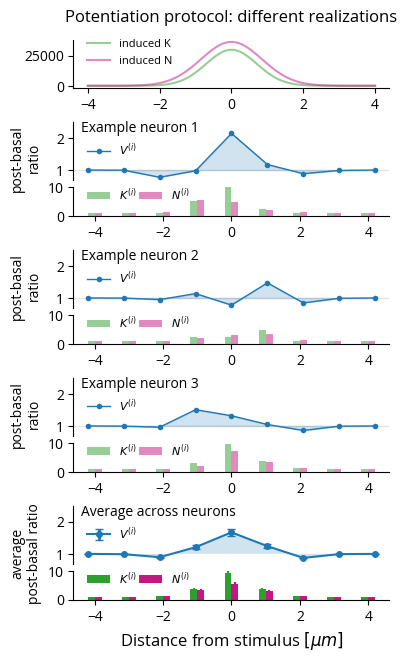

In [ ]:
fig = plt.figure(figsize=(4,7))
fig.subplots_adjust(left=0.2, bottom=0.1, right=0.99, top=.9)

plot_plasticity_visualization(fig)
# plt.savefig('docs/figures-paper/svgs/plasticity-variability.svg')


/tmp/ipykernel_597971/3033269788.py:44: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  basal_size = alpha / (R + alpha)
/tmp/ipykernel_597971/3033269788.py:45: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  post_size = alpha_prime / (R + deltaR + alpha_prime)
/tmp/ipykernel_597971/3033269788.py:34: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  (1 + deltaR/R + deltaR/R/mpd['Ns'] * N)


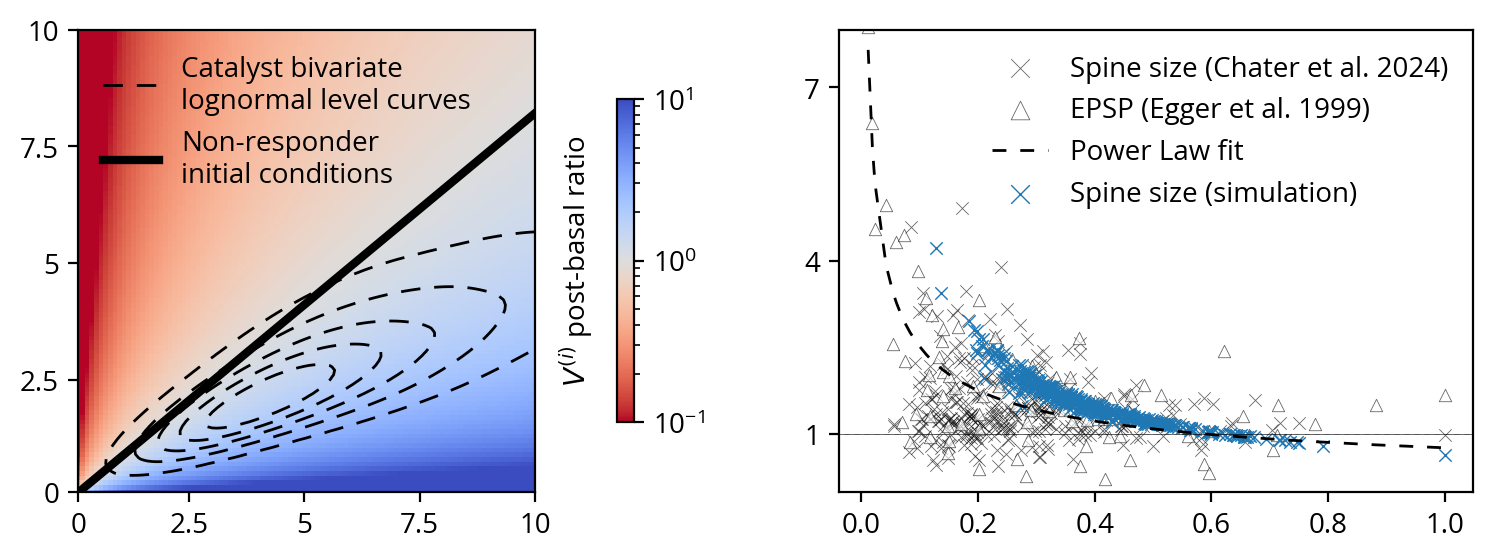

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(9,3), dpi=200, width_ratios=(1,1))

fig.subplots_adjust(wspace=0.2, hspace=0.6)

mpd = deepcopy(model_p_dict)
plot_plasticity_phase_space(axs[0], mpd, seed=1)
plot_size_rel_variation_pot(axs[1])

# plt.savefig('docs/figures-paper/svgs/size-dep-pot.png', dpi=300)


/tmp/ipykernel_597971/3033269788.py:44: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  basal_size = alpha / (R + alpha)
/tmp/ipykernel_597971/3033269788.py:45: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  post_size = alpha_prime / (R + deltaR + alpha_prime)
/tmp/ipykernel_597971/3033269788.py:34: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  (1 + deltaR/R + deltaR/R/mpd['Ns'] * N)


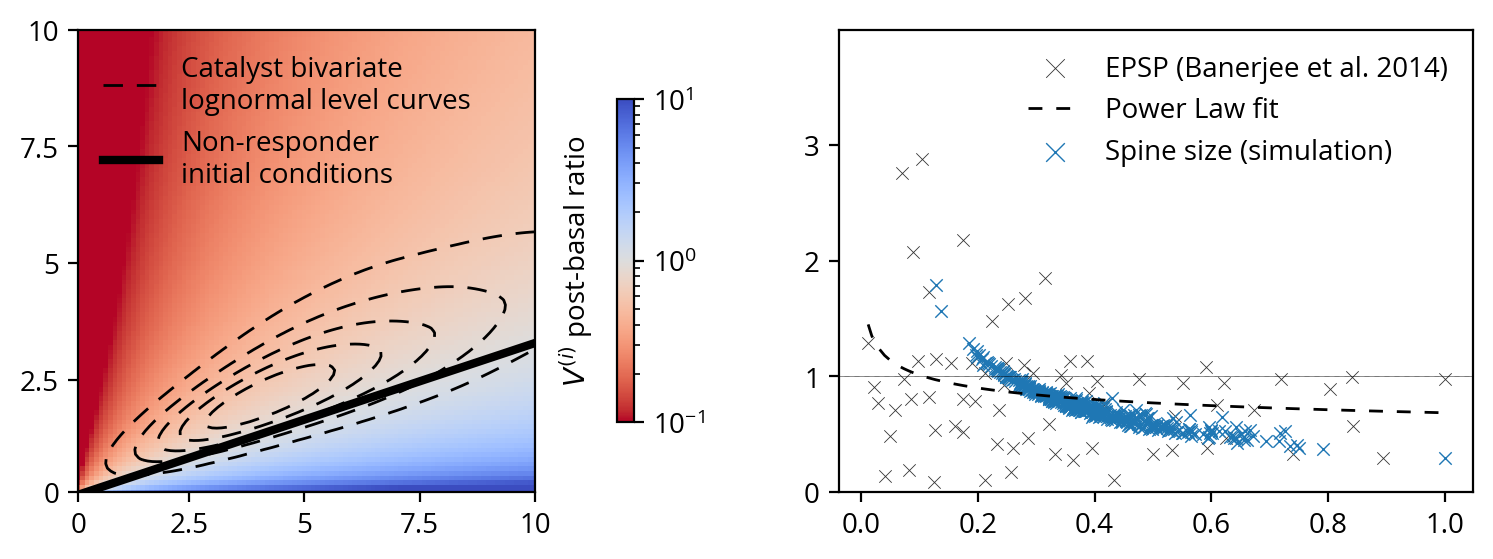

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(9,3), dpi=200, width_ratios=(1,1))

fig.subplots_adjust(wspace=0.2, hspace=0.6)

mpd = deepcopy(model_p_dict)
mpd['Ks'] *= 0.4
plot_plasticity_phase_space(axs[0], mpd, seed=1)
plot_size_rel_variation_dep(axs[1])

/tmp/ipykernel_597971/3033269788.py:44: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  basal_size = alpha / (R + alpha)
/tmp/ipykernel_597971/3033269788.py:45: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  post_size = alpha_prime / (R + deltaR + alpha_prime)
/tmp/ipykernel_597971/3033269788.py:34: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  (1 + deltaR/R + deltaR/R/mpd['Ns'] * N)


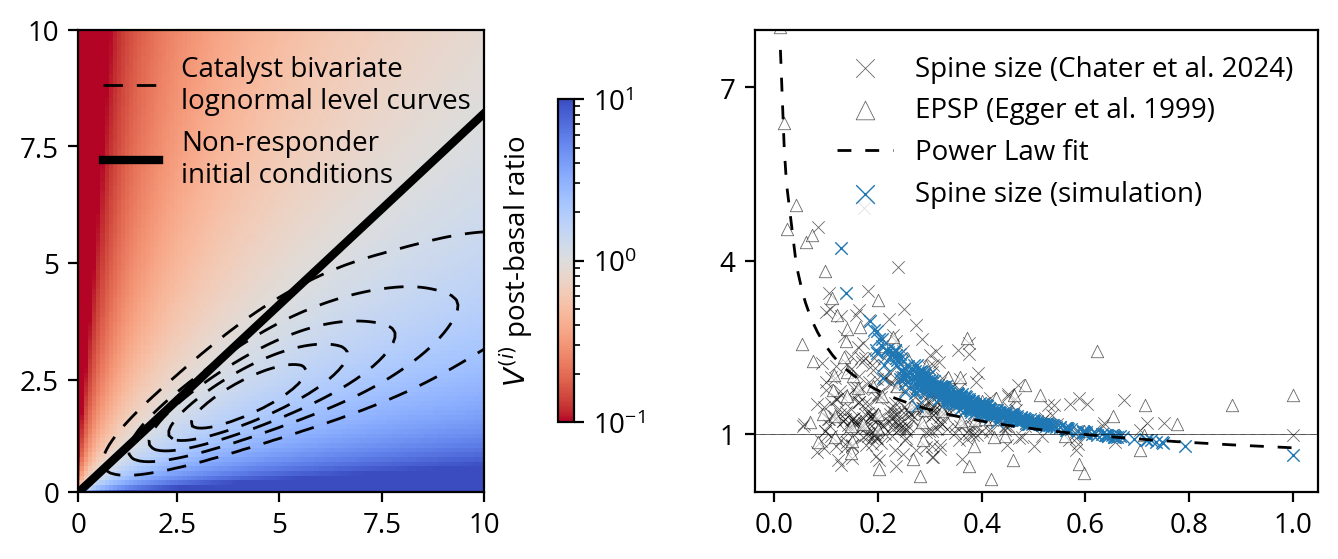

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(8,3), dpi=200)

fig.subplots_adjust(wspace=0.2, hspace=0.6)

mpd = deepcopy(model_p_dict)
plot_plasticity_phase_space(axs[0], mpd, seed=1)
plot_size_rel_variation_pot(axs[1])
